In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_mldata

#### 读取数据集
    
__注意：__ 当使用 __fetch_mldata__ 读取数据时，要将数据集放在 __mldata__ 目录下。

In [11]:
mnist = fetch_mldata('MNIST original',data_home='./')
mnist
X,y = mnist['data'],mnist['target']

D:\python\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
D:\python\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
X.shape

(70000, 784)

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

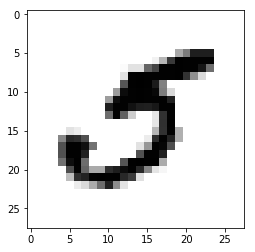

In [14]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation='nearest')

In [15]:
y[36000]

5.0

In [17]:
x_train,x_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

因为有的算法可能会受到训练样例的顺序的影响，当在一行中得到许多相似的样例，算法的效果会很差，所以随机打乱

In [19]:
shuffle_index = np.random.permutation(60000)
x_train,y_train = x_train[shuffle_index],y_train[shuffle_index]

In [23]:
x_train.shape

(60000, 784)

In [21]:
y_train.shape

(60000,)

#### 训练一个二分类器

现在我们简化一下问题，只尝试去识别一个数字，比如说，数字	5。这个“数字	5	检测器”就是 一个二分类器，能够识别两类别，“是	5”和“非	5”。让我们为这个分类任务创建目标向量：


In [24]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [25]:
y_train_5

array([False, False, False, ..., False, False, False])

使用 __随机梯度下降分类器 SGD__ 来训练它。

这个分类器有一个好处是能够高效地处理非常大的数据集。这部分原因在于 __SGD__ 一次只处理一条数据，这也使得 __SGD__ 适合在线学习。

__SGDClassifier__	依赖于训练集的随机程度（所以被命名为	stochastic，随机之义）。如果你想重现结果，你应该固定参数 __random_state__。

In [27]:
from sklearn.linear_model import SGDClassifier

In [28]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
display(sgd_clf.predict([X[36000]]))
y[36000]

array([ True])

5.0

识别成功

#### 对性能的评估
    
对性能评估最好的方法还是使用 __交叉验证__ 。

接下来还是使用交叉验证对训练模型进行评估。

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

__实现一个自己版本的交叉验证__

以下代码粗略地做了和	cross_val_score()	相同的事情，并且输出相同的结果。


In [38]:
skfold = StratifiedKFold(n_splits=3,random_state=42)

for train_index,test_index in skfold.split(x_train,y_train_5):
    sgd_clf_clone = clone(sgd_clf)
    
    x_train_fold = x_train[train_index]
    x_test_fold = x_train[test_index]
    
    y_train_5_fold = y_train_5[train_index]
    y_test_5_fold = y_train_5[test_index]
    
    sgd_clf_clone.fit(x_train_fold,y_train_5_fold)
    y_pred = sgd_clf_clone.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_5_fold)
    print(n_correct/len(y_pred))

0.96255
0.9488
0.9418


使用 cross_val_score() 函数来评估 SGDClassifier 模型

In [39]:
from sklearn.model_selection import cross_val_score

In [42]:
cross_val_score(sgd_clf,x_train,y_train_5,cv=3,scoring='accuracy')

array([0.96255, 0.9488 , 0.9418 ])

看起来分类效果好像很好，但是先别高兴，现在我们使用一个非常笨的分类器去分类，看看非5这个类上的表现。

#### 自定义一个估计器

需要继承 __BaseEstimator__ 。

因为 __BaseEstimator__ 中有 __get_params__ 和 __set_params__ 这两种方法，在下面的交叉验证中需要用到这两种方法。

In [53]:
BaseEstimator??

In [51]:
from sklearn.base import BaseEstimator

In [59]:
class Never5classifier(BaseEstimator):
    def fit(self,x,y=None):
        pass
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool)

In [65]:
never_5_clf.get_params

<bound method BaseEstimator.get_params of Never5classifier()>

In [66]:
sgd_clf.get_params

<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)>

需要继承 __BaseEstimator__ 才可以在交叉验证中使用 __Never5classifier__ 这个自定义的函数。

In [60]:
never_5_clf = Never5classifier() 
cross_val_score(never_5_clf,x_train,y_train_5,scoring='accuracy')

D:\python\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.9107 , 0.9082 , 0.91005])

可以看到即使预测结果全为False，那么准确率也高达90%。

这证明了精度不是一个很好的性能度量指标，接下来看 __混淆矩阵__

__cross_val_predict()__	也使用	K 折交叉验证。它不是返回一个评估分数，而是返回基于每一个测试折做出的一个预测值。这意味着，对于每一个训练集的样例，你得到一个干净的预测（“干净”是说一个模型在训练过程当中没有用到测试集的数据）

In [67]:
from sklearn.model_selection import cross_val_predict

In [68]:
y_train_pred = cross_val_predict(sgd_clf,x_train,y_train_5,cv=3)

In [69]:
y_train_pred

array([False, False, False, ..., False, False, False])

### 混淆矩阵

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
confusion_matrix(y_train_5,y_train_pred)

array([[53480,  1099],
       [ 1838,  3583]], dtype=int64)

混淆矩阵中的每一行表示一个实际的类,	而每一列表示一个预测的类。

该矩阵的第一行认为“非 5”（反例）中的	53272	张被正确归类为	“非	5”（他们被称为真反例,true negatives）,	而其余 1099 被错误归类为 "是5"	（假正例，false	positives）。第二行认为“是	5”	（正例）中的	1838 被错误地归类为 “非5”（假反例，false	negatives），其余	3583	正确分类为	“是5”类（真正例，true	positives）

### 准确率和召回率的折衷

在 __SGD__ 中来划分一个图片是不是某个数值，依靠的是 __阈值__。

__Scikit-Learn__ 不让你直接设置阈值，但是它给你提供了设置决策分数的方法，这个决策分数可 以用来产生预测。

它不是调用分类器的	predict() 方法，而是调用 __decision_function()__ 方法。

__这个方法返回每一个样例的分数值，然后基于这个分数值，使用你想要的任何阈值做出预测。__


In [72]:
# 通过 decision_function 来计算some_digit这个图片的决策分数。
y_score = sgd_clf.decision_function([some_digit])
y_score

array([3411.33155565])

__根据决策分数和阈值进行对比，如果决策分数大于阈值，则视为正类，反之视为负类。__

In [76]:
threshold = 0
y_some_digit_pre = (y_score >threshold)
y_some_digit_pre

array([ True])

In [77]:
threshold = 4000
y_some_digit_pre = (y_score >threshold)
y_some_digit_pre

array([False])

__这证明了提高阈值会降调召回率__

__那么，你应该如何使用哪个阈值呢？__

首先，你需要再次使用	__cross_val_predict()__	得到每一个样例的分数值，但是这一次指定返回一个 __决策分数__ ，而不是预测值。

__decision_function__ 方法返回每个实例的分数，然后就可以根据这些分数，使用任意阈值进行预测。

In [80]:
y_score = cross_val_predict(sgd_clf,x_train,y_train_5,cv=3,method='decision_function')
y_score

array([-22250.67613903, -13896.49860594, -29003.73878143, ...,
        -9836.89786869, -55507.90575443,   -703.42888522])

现在有了这些分数值。对于任何可能的阈值，使用 __precision_recall_curve()__ (计算不同概率阈值的精确召回对) 。

可以用于计算 __准确率__ 和 __召回率__

In [79]:
from sklearn.metrics import precision_recall_curve

__注意：__ 得到的 __threshold__ 的shape和 __precision__ 和 __recall__ 的shape都不一样，所以在绘制图像的使用要加上 __[0:-1]__,会截取到最后一个数(但是不包含)。

__因为绘制时x和y的shape要相同。__

In [81]:
precision,recall,threshold = precision_recall_curve(y_train_5,y_score)

In [110]:
print('precision[:-1].shape: ',precision[:-1].shape)
print('precision.shape: ',precision.shape)
print('threshold.shape: ',threshold.shape)

precision[:-1].shape:  (59964,)
precision.shape:  (59965,)
threshold.shape:  (59964,)


#### 绘制精确率和召回率的曲线
    
__准确率__ 不一定随着 __阈值__ 的增加而上升，但是 __召回率__ 一定会随着 __阈值__ 的增加而上升。

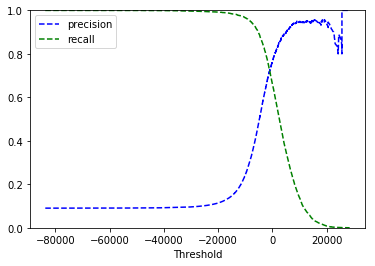

In [97]:
def precision_recall_vs_threshold(precision,recall,threshold):
    plt.plot(threshold,precision[:-1],'b--',label='precision')
    plt.plot(threshold,recall[:-1],'g--',label='recall')
    plt.legend(loc='upper left')
    plt.xlabel('Threshold')
    plt.ylim(0,1)

precision_recall_vs_threshold(precision,recall,threshold)
plt.show()

In [111]:
from sklearn.metrics import recall_score,precision_score

检验在 __准确度为90%时__，阈值的大小。

In [115]:
y_train_pred_90 = (y_score > 20000)
display(precision_score(y_train_5,y_train_pred_90))
recall_score(y_train_5,y_train_pred_90)

0.9361702127659575

0.008116583656152001

#### PR曲线

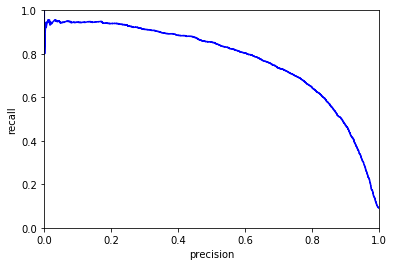

In [126]:
def plot_pr(precision,recall):
    plt.plot(recall,precision,'b')
    plt.axis([0,1,0,1])
    plt.xlabel('precision')
    plt.ylabel('recall')    

plot_pr(precision,recall)

#### ROC曲线

为了画出 __ROC 曲线__ ，你首先需要计算各种不同阈值下的 __TPR__、 __FPR__ 使用 __roc_curve()__ 函数 。

In [116]:
from sklearn.metrics import roc_curve

In [117]:
fpr,tpr,threshold = roc_curve(y_train_5,y_score)

#### 这里同样存在折衷的问题：

__召回率（TPR）越高__ ，分类器就会 __产生越多的假正例（FPR）__ 。 

图中的点线是一个完全随机的分类器生成的 ROC 曲线； __一个好的分类器的 ROC 曲线应该尽可能远离这条线（即向左上角方向靠拢）__

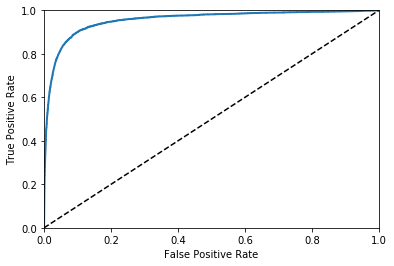

In [124]:
def plt_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    # 绘制副对角线
    plt.plot([0,1],[0,1],'k--')
    # 设置图像坐标
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')            
plt_roc_curve(fpr,tpr)

#### 一个比较分类器之间优劣的方法是：

测量ROC曲线下的面积（AUC）。 __一个完美的分类器的 ROC	AUC	等于 1，而一个纯随机分类器的	ROC	AUC	等于 0.5。__

Scikit-Learn 提供了一个函数来计算	ROC	AUC： __roc_auc_score__。 即计算AUC的面积。

In [127]:
from sklearn.metrics import roc_auc_score

In [128]:
roc_auc_score(y_train_5,y_score)

0.9550323286098804